# Homework 2

## 2. Eigenfaces and Simple Face Recognition

In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpl_img
from PIL import Image

In [2]:
pic_name01 = ['data/yalefaces/subject01.glasses.gif',
              'data/yalefaces/subject01.happy.gif',
              'data/yalefaces/subject01.leftlight.gif',
              'data/yalefaces/subject01.noglasses.gif',
              'data/yalefaces/subject01.normal.gif',
              'data/yalefaces/subject01.rightlight.gif',
              'data/yalefaces/subject01.sad.gif',
              'data/yalefaces/subject01.sleepy.gif',
              'data/yalefaces/subject01.surprised.gif',
              'data/yalefaces/subject01.wink.gif']
pic_name02 = ['data/yalefaces/subject02.glasses.gif',
              'data/yalefaces/subject02.happy.gif',
              'data/yalefaces/subject02.leftlight.gif',
              'data/yalefaces/subject02.noglasses.gif',
              'data/yalefaces/subject02.normal.gif',
              'data/yalefaces/subject02.rightlight.gif',
              'data/yalefaces/subject02.sad.gif',
              'data/yalefaces/subject02.sleepy.gif',
              'data/yalefaces/subject02.wink.gif']

for i in range(1,3):
    if i==1:
        pic_name = pic_name01
    else:
        pic_name = pic_name02
        
    for j in range(len(pic_name)):
        path = pic_name[j]
        
        try:
            # Import image
            img = np.array(Image.open(path))
        except:
            print(path + ' does not exist!')

        # Downsize each image
        img2 = img[::4, ::4]

        # Vectorize each image
        # https://necromuralist.github.io/neural_networks/posts/image-to-vector/
        new_img = img2.reshape((1, img2.shape[0] * img2.shape[1]))
#         print(path, img.shape, new_img.shape) 

        # Append image to S1 and S2 matricies
        if i==1:
            if j==0:
                S1 = new_img
            else:
                S1 = np.append(S1, new_img, axis=0)
        else:
            if j==0:
                S2 = new_img
            else:
                S2 = np.append(S2, new_img, axis=0)  
                
m1,n1 = S1.shape
m2,n2 = S2.shape
                
# Get mean of each image
S1_mean = np.mean(S1,axis = 0)
S2_mean = np.mean(S2,axis = 0)

# # Standardize the matrices
X1 = (S1.T - S1_mean[:,None])
X2 = (S2.T - S2_mean[:,None])

# Perform SVD
U1,Sig1,V1 = np.linalg.svd(X1) 
U2,Sig1,V2 = np.linalg.svd(X2) 

# Save each eigenface
for i in range(6):
    e_img1 = U1[:, i].reshape(61,80)
    e_img2 = U2[:, i].reshape(61,80)
    mpl_img.imsave('Q2_output/eigenface1_'+str(i)+'.png', e_img1, cmap='gray')
    mpl_img.imsave('Q2_output/eigenface2_'+str(i)+'.png', e_img2, cmap='gray')

### Part B

In [4]:
# Get top eigenvectors
top_1 = U1[:,0:6]
top_2 = U2[:,0:6]

# top_1 = top_1.reshape(4880,1)
# top_2 = top_2.reshape(4880,1)

# Import test images
test_1 = np.array(Image.open('data/yalefaces/subject01-test.gif'))
test_2 = np.array(Image.open('data/yalefaces/subject02-test.gif'))

# Resize
test_1 = test_1[::4, ::4]
test_2 = test_2[::4, ::4]

# Vectorize
test_1 = test_1.reshape((test_1.shape[0] * test_1.shape[1], 1))
test_2 = test_2.reshape((test_2.shape[0] * test_2.shape[1], 1))

# Mean Center
test_1 = (test_1 - S1_mean[:,None])
test_2 = (test_2 - S2_mean[:,None])

# Compute Residuals
s11 = np.linalg.norm(test_1 - (np.dot(top_1,top_1.T))@test_1)**2
s12 = np.linalg.norm(test_2 - (np.dot(top_1,top_1.T))@test_2)**2
s21 = np.linalg.norm(test_1 - (np.dot(top_2,top_2.T))@test_1)**2
s22 = np.linalg.norm(test_2 - (np.dot(top_2,top_2.T))@test_2)**2

In [5]:
 # Compares the performance of eigvector of subject 1 vs test 1 and test 2
s11, s21, s11 < s21

(6091271.162235055, 6267943.44519444, True)

In [6]:
s12, s22, s22 < s12

(4503195.206097447, 2560011.9287058124, True)

## 3. Order of Faces using ISOMAP

### Part A

In [7]:
import scipy.io as spio
import sklearn.utils.graph_shortest_path as sp
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import random as rand 

### Tune Epsilon for L2 Norm
Try different values of epsilon, comparing results to figure in lecture and visually inspecting which value of epsilon produces similar results.

(array([[  1.,   3.,  20., ...,  13.,   2.,   0.],
        [  1.,   1.,   4., ...,  40.,   5.,   0.],
        [  2.,   5.,  16., ...,  14.,   1.,   0.],
        ...,
        [  4.,  19.,  49., ..., 123.,  59.,  13.],
        [  1.,   1.,   6., ..., 134.,  78.,   4.],
        [  2.,   1.,  18., ...,  97.,  25.,   0.]]),
 array([ 0.        ,  3.46871685,  6.9374337 , 10.40615054, 13.87486739,
        17.34358424, 20.81230109, 24.28101794, 27.74973479, 31.21845163,
        34.68716848]),
 <a list of 698 BarContainer objects>)

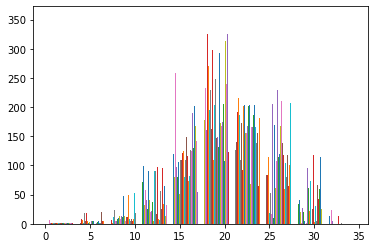

In [8]:
# Explore distribution of data

images = spio.loadmat('data/isomap.mat',squeeze_me=True)['images'].T
m,n = images.shape

# Build weighted graph A 
A = np.zeros(shape = (m,m))
for i in range(m):
    for j in range(m):
        A_i = images[i]
        distance = np.linalg.norm(images[i]-images[j])
        A[i,j] = distance
    
plt.hist(A)

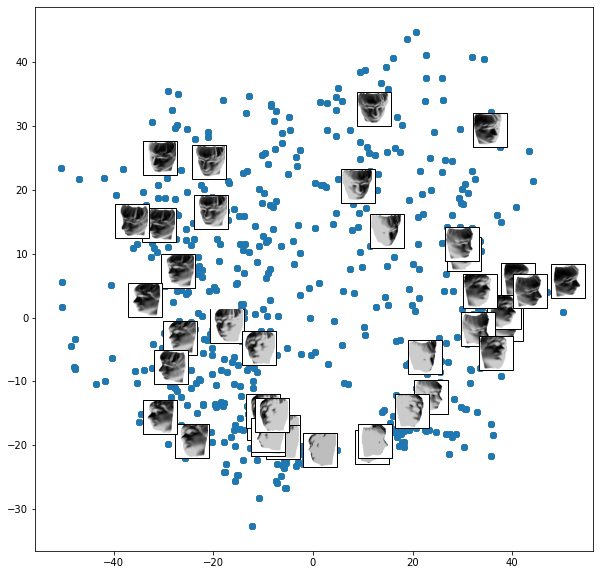

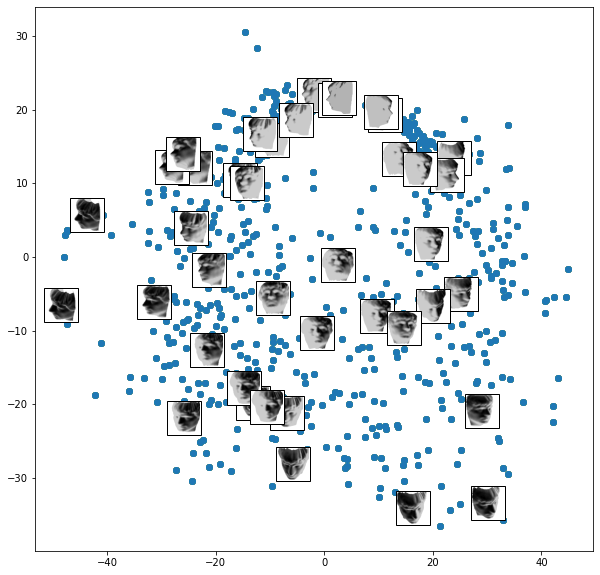

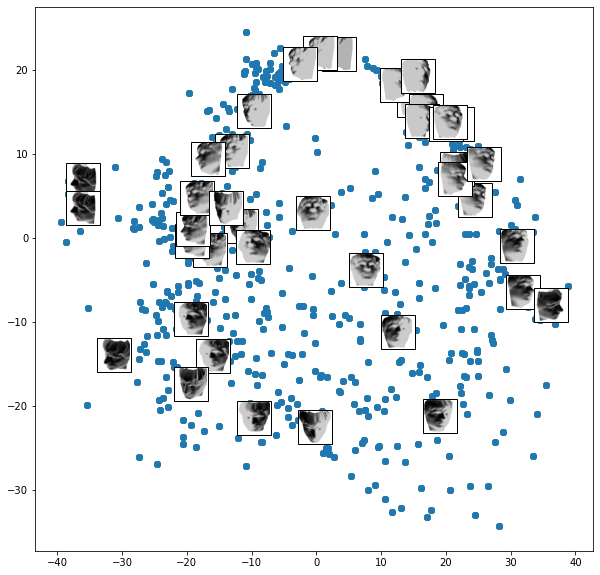

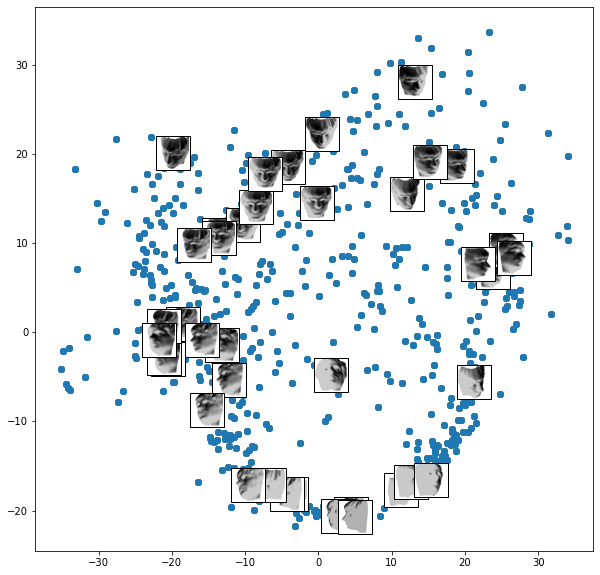

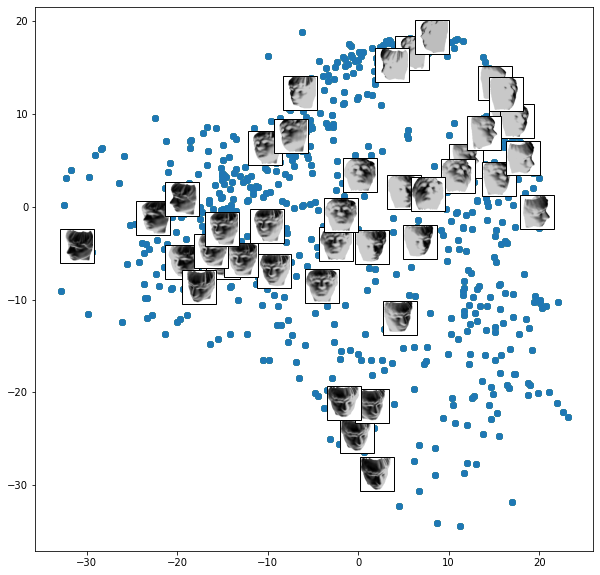

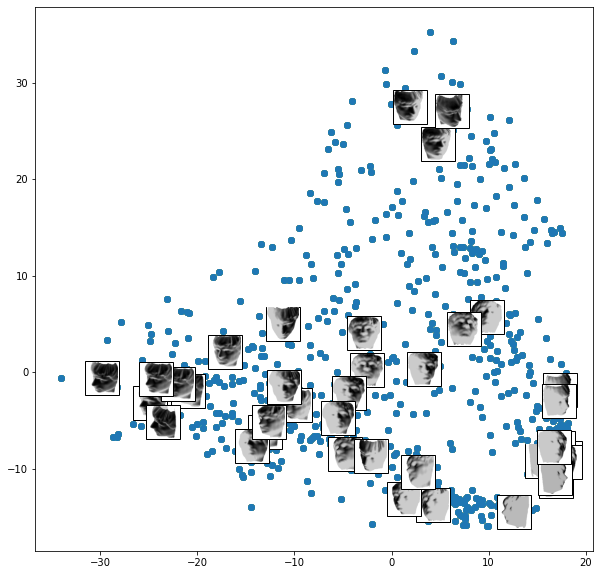

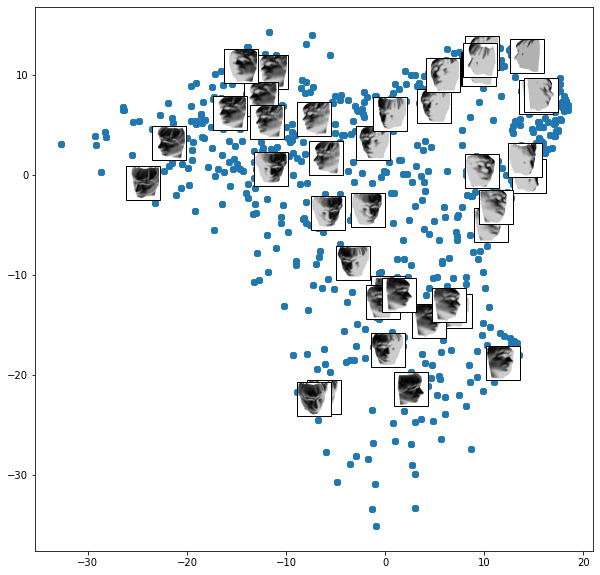

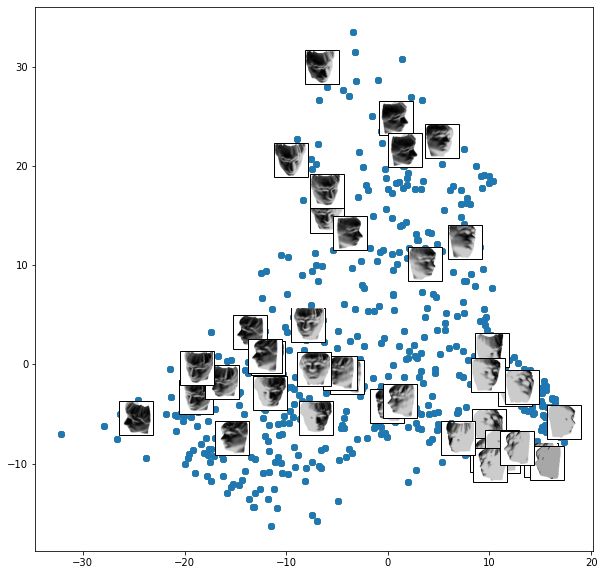

In [10]:
# eps = [5,10,15,20,25]
eps = [11,12,13,14,16,17,18,19]

for e in eps:
    images = spio.loadmat('data/isomap.mat',squeeze_me=True)['images'].T
    m,n = images.shape

    # Build weighted graph A 
    A = np.zeros(shape = (m,m))
    for i in range(m):
        for j in range(m):
            A_i = images[i]

            # Tune epsilon based on final graph
            epsilon = e 
            distance = np.linalg.norm(images[i]-images[j])
            if distance <= epsilon:
                A[i,j] = distance
            else:
                A[i,j] = 0

    #  Compute pairwise shortest distance matrix 𝐷
    D = sp.graph_shortest_path(A)

    # Centering matrix, H = I - (1/m)11.T, C = (-1/2)HD^2H
    I = np.identity(m)
    ones = np.ones(shape = (698))
    H = I - (1/m)*np.outer(ones, ones.T)
    C = (-1/2)*H@(D**2)@H

    # Compute eigenvalues
    U_C,Sig_C,V_C = np.linalg.svd(C) 

    # Extract first 2 eigenvectors
    dim_1 = U_C[:,0]*np.sqrt(Sig_C[0])
    dim_2 = U_C[:,1]*np.sqrt(Sig_C[1])

    # Graph ISOMAP results
    # https://stackoverflow.com/questions/4860417/placing-custom-images-in-a-plot-window-as-custom-data-markers-or-to-annotate-t/4872190
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(dim_1,dim_2)

    # Add photos
    sample = rand.sample(range(m), 40)

    for i in sample:
        img = images[i,:].reshape(64, 64).T
        ab = AnnotationBbox(OffsetImage(img, cmap = 'gray_r',zoom=0.5,), (dim_1[i],dim_2[i]) ,pad=0.1)
        ax.add_artist(ab)
        ax.scatter(dim_1,dim_2)
    
    fig.savefig('Q3_output/Part_B/epsilon_'+str(e)+'.png')

### Generate Adjaceny Matrix

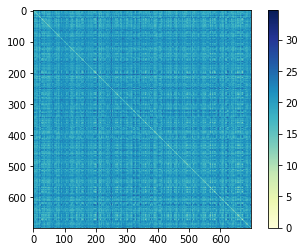

In [11]:
### Adjacency with no epsilon adjustment

# Import data, transpose so each row is an image
images = spio.loadmat('data/isomap.mat',squeeze_me=True)['images'].T
m,n = images.shape

# Build weighted graph A 
A = np.zeros(shape = (m,m))
for i in range(m):
    for j in range(m):
        A_i = images[i]
        distance = np.linalg.norm(images[i]-images[j])
        A[i,j] = distance
       
# Show adjacency matrix
plt.imshow(A, cmap = 'YlGnBu')
plt.colorbar()
plt.show()

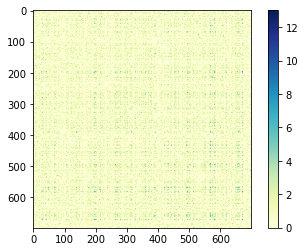

In [12]:
## Adjacency Matrix with Tuned Epsilon

# Import data, transpose so each row is an image
images = spio.loadmat('data/isomap.mat',squeeze_me=True)['images'].T
m,n = images.shape

# Build weighted graph A 
A = np.zeros(shape = (m,m))
for i in range(m):
    for j in range(m):
        A_i = images[i]
        
        # Tuned epsilon based on resulting graph from part B
        epsilon = 13
        distance = np.linalg.norm(images[i]-images[j])
        if distance <= epsilon:
            A[i,j] = distance
        else:
            A[i,j] = 0

# Show adjacency matrix
plt.imshow(A, cmap = 'YlGnBu')
plt.colorbar()
plt.show()

### Part B

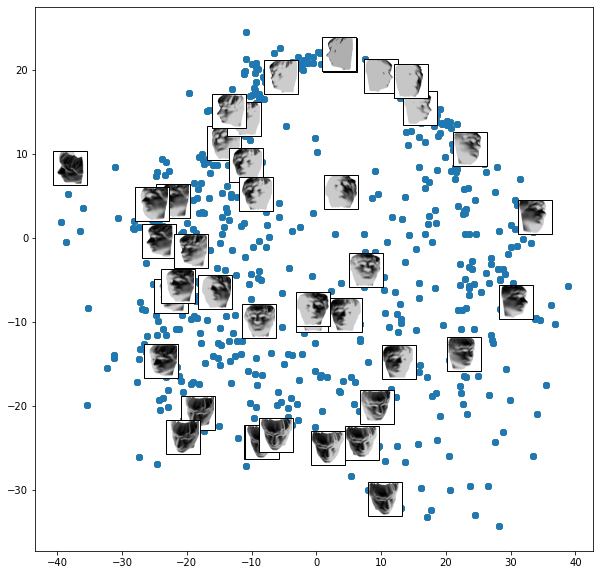

In [13]:
#  Compute pairwise shortest distance matrix 𝐷
D = sp.graph_shortest_path(A)

# Centering matrix, H = I - (1/m)11.T, C = (-1/2)HD^2H
I = np.identity(m)
ones = np.ones(shape = (698))
H = I - (1/m)*np.outer(ones, ones.T)
C = (-1/2)*H@(D**2)@H

# Compute eigenvalues
U_C,Sig_C,V_C = np.linalg.svd(C) 

# Extract first 2 eigenvectors
dim_1 = U_C[:,0]*np.sqrt(Sig_C[0])
dim_2 = U_C[:,1]*np.sqrt(Sig_C[1])

# Graph ISOMAP results
# https://stackoverflow.com/questions/4860417/placing-custom-images-in-a-plot-window-as-custom-data-markers-or-to-annotate-t/4872190
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(dim_1,dim_2)

# Add photos
sample = rand.sample(range(m), 40)

for i in sample:
    img = images[i,:].reshape(64, 64).T
    ab = AnnotationBbox(OffsetImage(img, cmap = 'gray_r',zoom=0.5,), (dim_1[i],dim_2[i]) ,pad=0.1)
    ax.add_artist(ab)
    ax.scatter(dim_1,dim_2)
    
fig.savefig('Q3_output/Report Output/Part B.png')

### Part C

### Tune Epsilon for L1 Norm
Try different values of epsilon, comparing results to figure in lecture and visually inspecting which value of epsilon produces similar results.

(array([[  1.,  13.,  68., ...,   4.,   0.,   0.],
        [  2.,   6., 115., ...,  16.,   0.,   0.],
        [  2.,  13.,  65., ...,   4.,   0.,   0.],
        ...,
        [ 20.,  59.,  83., ...,  73.,  23.,   1.],
        [  1.,   5.,  33., ...,  71.,  42.,   2.],
        [  3.,  29., 108., ...,  55.,   6.,   0.]]),
 array([   0.        ,  190.11951593,  380.23903186,  570.35854779,
         760.47806373,  950.59757966, 1140.71709559, 1330.83661152,
        1520.95612745, 1711.07564338, 1901.19515931]),
 <a list of 698 BarContainer objects>)

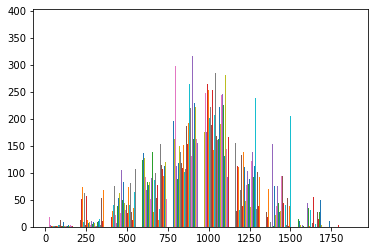

In [14]:
# Explore distribution of data
images = spio.loadmat('data/isomap.mat',squeeze_me=True)['images'].T
m,n = images.shape

# Build weighted graph A 
A = np.zeros(shape = (m,m))
for i in range(m):
    for j in range(m):
        A_i = images[i]
        distance = np.linalg.norm(images[i]-images[j], ord=1)
        A[i,j] = distance
    
plt.hist(A)

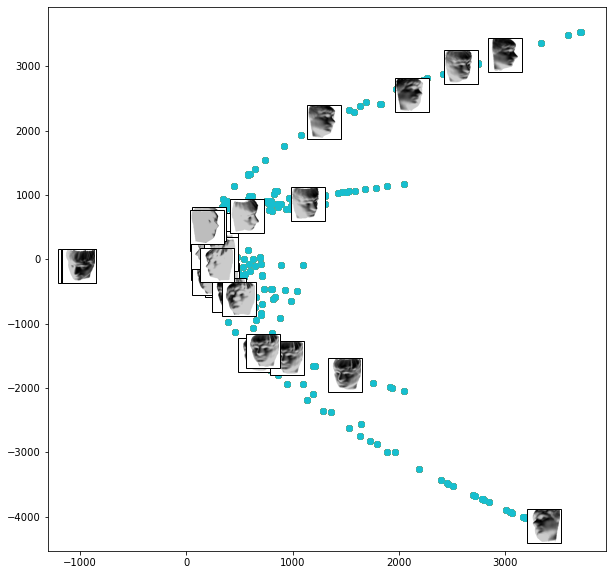

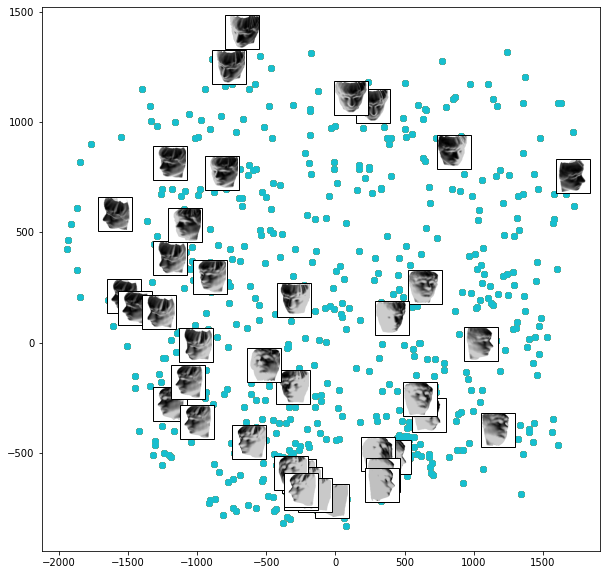

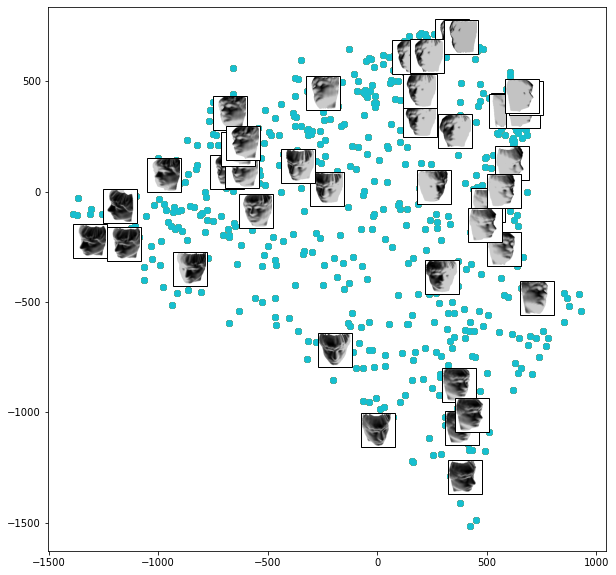

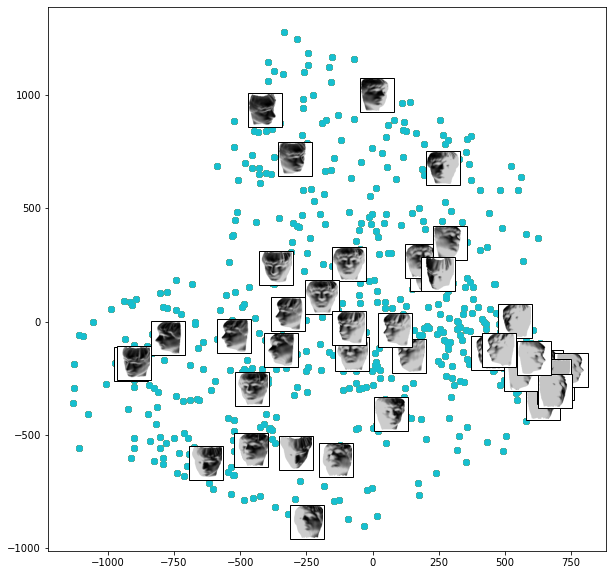

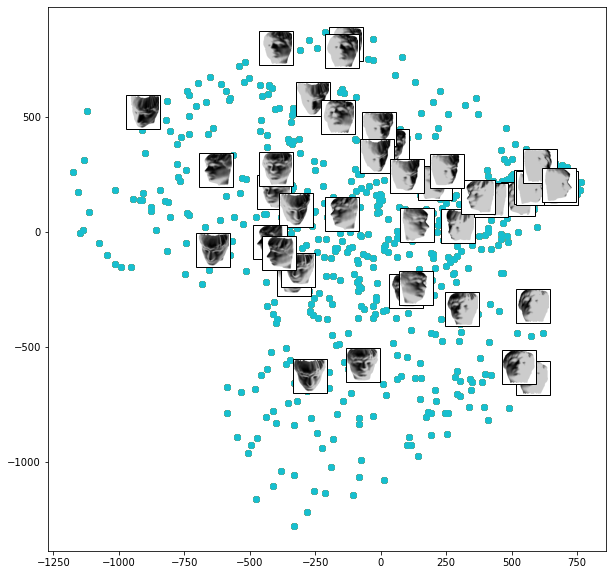

In [16]:
eps = [250,500,750,1000,1250]
# eps = [550, 600, 650, 750, 800, 850, 900, 950]


for e in eps:
    images = spio.loadmat('data/isomap.mat',squeeze_me=True)['images'].T
    m,n = images.shape

    # Build weighted graph A 
    A = np.zeros(shape = (m,m))
    for i in range(m):
        for j in range(m):
            A_i = images[i]

            # Tune epsilon based on final graph
            epsilon = e 
            distance = np.linalg.norm(images[i]-images[j], ord=1)
            if distance <= epsilon:
                A[i,j] = distance
            else:
                A[i,j] = 0

    #  Compute pairwise shortest distance matrix 𝐷
    D = sp.graph_shortest_path(A)

    # Centering matrix, H = I - (1/m)11.T, C = (-1/2)HD^2H
    I = np.identity(m)
    ones = np.ones(shape = (698))
    H = I - (1/m)*np.outer(ones, ones.T)
    C = (-1/2)*H@(D**2)@H

    # Compute eigenvalues
    U_C,Sig_C,V_C = np.linalg.svd(C) 

    # Extract first 2 eigenvectors
    dim_1 = U_C[:,0]*np.sqrt(Sig_C[0])
    dim_2 = U_C[:,1]*np.sqrt(Sig_C[1])

    # Graph ISOMAP results
    # https://stackoverflow.com/questions/4860417/placing-custom-images-in-a-plot-window-as-custom-data-markers-or-to-annotate-t/4872190
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(dim_1,dim_2, color = 'g')

    # Add photos
    sample = rand.sample(range(m), 40)

    for i in sample:
        img = images[i,:].reshape(64, 64).T
        ab = AnnotationBbox(OffsetImage(img, cmap = 'gray_r',zoom=0.5,), (dim_1[i],dim_2[i]) ,pad=0.1)
        ax.add_artist(ab)
        ax.scatter(dim_1,dim_2)
    
    fig.savefig('Q3_output/Part_C/epsilon_'+str(e)+'.png')

### Adjacency Matrices

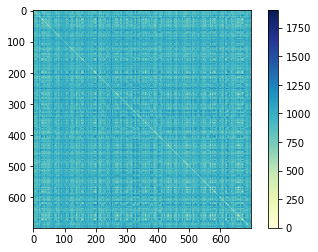

In [17]:
### Adjacency with no epsilon adjustment

# Import data, transpose so each row is an image
images = spio.loadmat('data/isomap.mat',squeeze_me=True)['images'].T
m,n = images.shape

# Build weighted graph A 
A = np.zeros(shape = (m,m))
for i in range(m):
    for j in range(m):
        A_i = images[i]
        distance = np.linalg.norm(images[i]-images[j], ord=1)
        A[i,j] = distance
       
# Show adjacency matrix
plt.imshow(A, cmap = 'YlGnBu')
plt.colorbar()
plt.show()

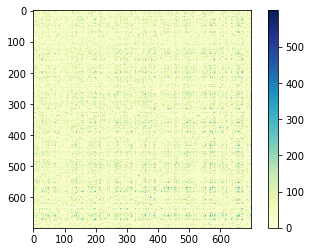

In [18]:
## Adjacency Matrix with Tuned Epsilon

# Import data, transpose so each row is an image
images = spio.loadmat('data/isomap.mat',squeeze_me=True)['images'].T
m,n = images.shape

# Build weighted graph A 
A = np.zeros(shape = (m,m))
for i in range(m):
    for j in range(m):
        A_i = images[i]
        
        # Tuned epsilon based on resulting graph from above loop
        epsilon = 600
        distance = np.linalg.norm(images[i]-images[j], ord=1)
        if distance <= epsilon:
            A[i,j] = distance
        else:
            A[i,j] = 0
            
# Show adjacency matrix
plt.imshow(A, cmap = 'YlGnBu')
plt.colorbar()
plt.show()

### ISOMAP with L1 Norm

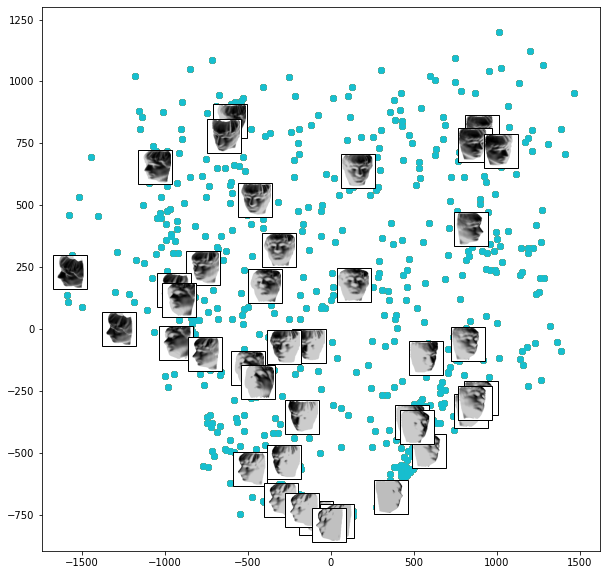

In [19]:
# Import data, transpose so each row is an image
images = spio.loadmat('data/isomap.mat',squeeze_me=True)['images'].T
m,n = images.shape

# Build weighted graph A 
A = np.zeros(shape = (m,m))
for i in range(m):
    for j in range(m):
        A_i = images[i]
        
        # Tuned epsilon based on resulting graph from above loop
        epsilon = 600
        distance = np.linalg.norm(images[i]-images[j], ord=1)
        if distance <= epsilon:
            A[i,j] = distance
        else:
            A[i,j] = 0

#  Compute pairwise shortest distance matrix 𝐷
D = sp.graph_shortest_path(A)

# Centering matrix, H = I - (1/m)11.T, C = (-1/2)HD^2H
I = np.identity(m)
ones = np.ones(shape = (698))
H = I - (1/m)*np.outer(ones, ones.T)
C = (-1/2)*H@(D**2)@H

# Compute eigenvalues
U_C,Sig_C,V_C = np.linalg.svd(C) 

# Extract first 2 eigenvectors
dim_1 = U_C[:,0]*np.sqrt(Sig_C[0])
dim_2 = U_C[:,1]*np.sqrt(Sig_C[1])

# Graph ISOMAP results
# https://stackoverflow.com/questions/4860417/placing-custom-images-in-a-plot-window-as-custom-data-markers-or-to-annotate-t/4872190
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(dim_1,dim_2, color='g')

# Add photos
sample = rand.sample(range(m), 40)

for i in sample:
    img = images[i,:].reshape(64, 64).T
    ab = AnnotationBbox(OffsetImage(img, cmap = 'gray_r',zoom=0.5,), (dim_1[i],dim_2[i]) ,pad=0.1)
    ax.add_artist(ab)
    ax.scatter(dim_1,dim_2)

fig.savefig('Q3_output/Report Output/Part C.png')

### Part D

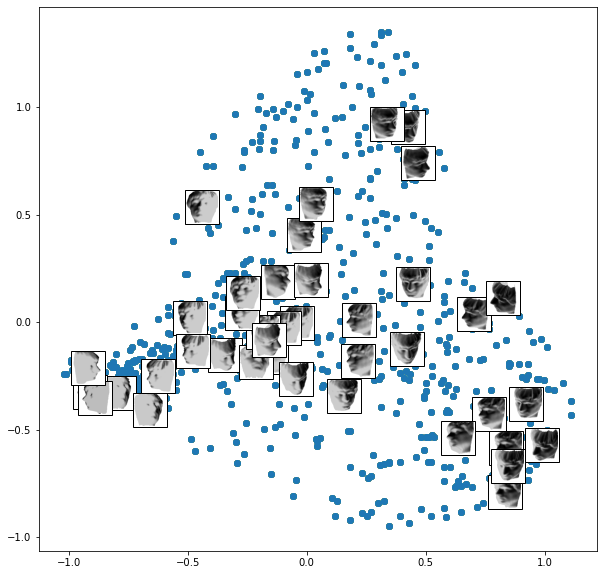

In [20]:
# PCA on original data set
img_mean = np.mean(images,axis = 0)
X_img = (images.T - img_mean[:,None])
U_X,Sig_X,V_X = np.linalg.svd(X_img)

U_X = U_X.real
Sig_X = Sig_X.real

dim_1 = np.dot(U_X[:,0].T,X_img)/np.sqrt(Sig_X[0])
dim_2 = np.dot(U_X[:,1].T,X_img)/np.sqrt(Sig_X[1])

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(dim_1,dim_2)
fig.savefig('Q3_output/Report Output/Part D Scatter Plot.png')

# Add photos
sample = rand.sample(range(m), 40)

for i in sample:
    img = images[i,:].reshape(64, 64).T
    ab = AnnotationBbox(OffsetImage(img, cmap = 'gray_r',zoom=0.5,), (dim_1[i],dim_2[i]) ,pad=0.1)
    ax.add_artist(ab)
    ax.scatter(dim_1,dim_2)

fig.savefig('Q3_output/Report Output/Part D Annotated.png')

## 4. PCA: Food Consumption in European Countries
### Part A

In [21]:
import pandas as pd

In [22]:
food_data = pd.read_csv('data/food-consumption.csv')
food_data.set_index('Country', inplace = True)
food_data.head()

,Real coffee,Instant coffee,Tea,Sweetener,Biscuits,Powder soup,Tin soup,Potatoes,Frozen fish,Frozen veggies,Apples,Oranges,Tinned fruit,Jam,Garlic,Butter,Margarine,Olive oil,Yoghurt,Crisp bread
Country,,,,,,,,,,,,,,,,,,,,
Germany,90,49,88,19,57,51,19,21,27,21,81,75,44,71,22,91,85,74,30,26
Italy,82,10,60,2,55,41,3,2,4,2,67,71,9,46,80,66,24,94,5,18
France,88,42,63,4,76,53,11,23,11,5,87,84,40,45,88,94,47,36,57,3
Holland,96,62,98,32,62,67,43,7,14,14,83,89,61,81,15,31,97,13,53,15
Belgium,94,38,48,11,74,37,23,9,13,12,76,76,42,57,29,84,80,83,20,5


In [27]:
food_data[:][['Garlic', 'Olive oil']]

,Garlic,Olive oil
Country,,
Germany,22,74
Italy,80,94
France,88,36
Holland,15,13
Belgium,29,83
Luxembourg,91,84
England,11,57
Portugal,89,92
Austria,51,28


<ipython-input-23-6a8112bc784b>:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X_food = food_data.T - food_mean[:,None]


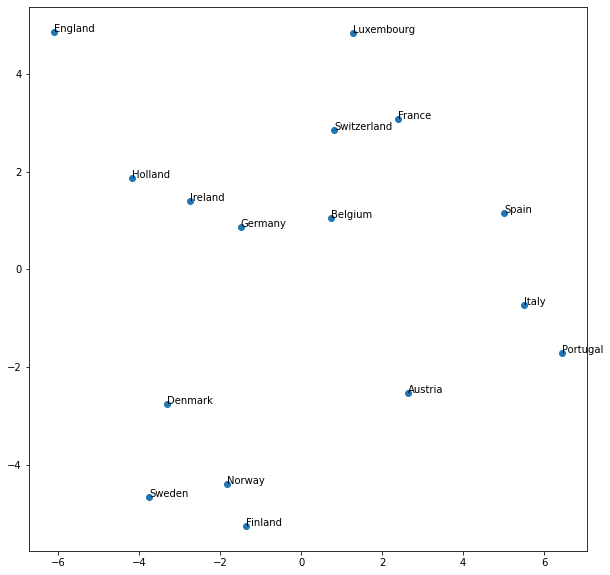

In [23]:
# Perform PCA

# Mean Center
food_mean = np.mean(food_data,axis = 0)
X_food = food_data.T - food_mean[:,None]

# SVD
U_f,Sig_f,V_f = np.linalg.svd(X_food)
U_f = U_f.real
Sig_f = Sig_f.real

# Find dimensions
dim_1 = np.dot(U_f[:,0].T,X_food)/np.sqrt(Sig_f[0])
dim_2 = np.dot(U_f[:,1].T,X_food)/np.sqrt(Sig_f[1])

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(dim_1,dim_2)

# Add labels
countries = list(X_food.columns)

for i in range(len(countries)):
    name = countries[i]
    ax.annotate(name, (dim_1[i], dim_2[i]))
    
fig.savefig('Q4_output/Part A.png')

### Part B

<ipython-input-25-62560e9d3593>:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X_food2 = food_data - food_mean2[:,None]


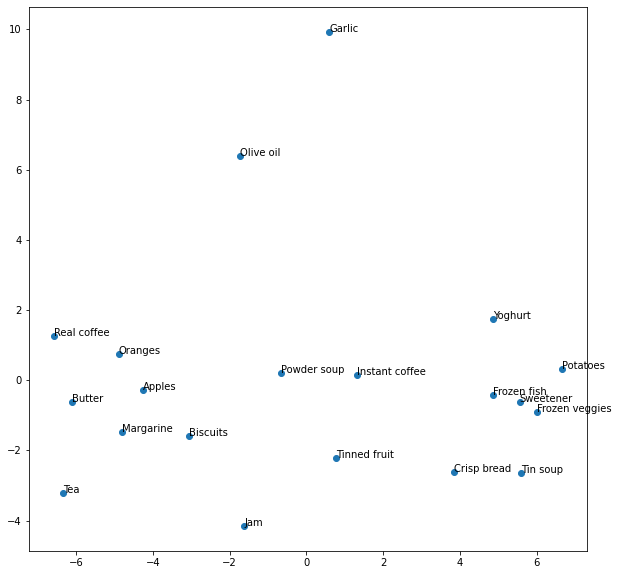

In [25]:
# Perform PCA

# Mean Center
food_mean2 = np.mean(food_data, axis = 1)
X_food2 = food_data - food_mean2[:,None]

# SVD
U_f2,Sig_f2,V_f2 = np.linalg.svd(X_food2)
U_f2 = U_f2.real
Sig_f2 = Sig_f2.real

# Find dimensions
dim_1 = np.dot(U_f2[:,0].T,X_food2)/np.sqrt(Sig_f2[0])
dim_2 = np.dot(U_f2[:,1].T,X_food2)/np.sqrt(Sig_f2[1])

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(dim_1,dim_2)

# Add labels
food_items = list(X_food2.columns)

for i in range(len(food_items)):
    name = food_items[i]
    ax.annotate(name, (dim_1[i], dim_2[i]))
    
fig.savefig('Q4_output/Part B.png')